##  A neural Network replacing the simple xgboost regression algorithm

#### Importing all libraries and setting the device to gpu

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_percentage_error
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
import random

# torch.cuda.set_device("cuda:0")
# print(torch.cuda.get_device_name())

In [2]:
import random
def set_seeds(seed=1234):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # multi-GPU
    
set_seeds()

#### Pre processing the data and adding data indicators to the data

In [3]:
df = pd.read_csv("../data/itc/itc.csv")
# Need to reverse the db
# df = df.loc[::-1]
df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)
df = df[(df['Date'].dt.year >= 2020)].copy()
df.index = range(len(df))
temp = df.copy()
# df['Close'] = (df['High'] + df['Low'] )/ 2
df.rename(columns={"Open Price":"Open","High Price":"High","Low Price":"Low","Close Price":"Close","Total Traded Quantity":"Volume","No.of Shares":"Volume"},inplace=True)
# cols = ["Symbol","Ser verbose=Falseies","Prev Close","Last Price","Average Price","Turnover","No. of Trades", "Deliverable Qty",'% Dly Qt to Traded Qty']
# cols = ["WAP","No. of Trades"	,"Total Turnover (Rs.)"	,"Deliverable Quantity"	,"% Deli. Qty to Traded Qty"	,"Spread High-Low"	,"Spread Close-Open"]
cols = "Adj Close"
df.drop(columns=cols,inplace=True)   
df.dropna(inplace=True)
df.head()

,Date,Open,High,Low,Close,Volume
0,2020-01-03,241.000000,241.000000,238.000000,238.500000,9284478
1,2020-01-06,237.500000,238.300003,235.000000,235.100006,7636617
2,2020-01-07,236.050003,237.899994,234.600006,235.350006,8416741
3,2020-01-08,234.000000,235.800003,233.250000,234.199997,7043211
4,2020-01-09,235.600006,236.600006,235.050003,235.800003,9452653


In [4]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0    
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

df['Close'] = df['Close'].shift(-1)

df = df.iloc[33:] # Because of moving average
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))

df.head()

,Date,Open,High,Low,Close,Volume,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2020-02-19,205.250000,207.149994,203.850006,207.449997,9054560,216.895122,208.260001,210.785001,215.796666,227.011666,26.402046,-6.574838,-6.189758
1,2020-02-20,207.000000,208.550003,205.449997,203.000000,15592846,215.846443,206.989999,209.810001,213.800000,226.094999,25.954847,-6.383968,-6.233273
2,2020-02-24,207.000000,207.449997,201.800003,201.800003,16594046,214.985241,206.100000,209.200000,212.026666,225.149999,43.333319,-6.495803,-6.290713
3,2020-02-25,203.800003,205.399994,201.500000,198.600006,15313516,213.759094,205.160001,208.160001,209.883333,223.983332,24.954789,-6.599209,-6.356965
4,2020-02-26,200.649994,201.949997,196.300003,197.550003,17869240,212.538435,204.560001,207.285001,209.496666,222.734999,20.299489,-6.846954,-6.460664


In [5]:
drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High']
df.drop(columns=drop_cols,inplace=True)
df.head()

,Close,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,207.449997,216.895122,208.260001,210.785001,215.796666,227.011666,26.402046,-6.574838,-6.189758
1,203.000000,215.846443,206.989999,209.810001,213.800000,226.094999,25.954847,-6.383968,-6.233273
2,201.800003,214.985241,206.100000,209.200000,212.026666,225.149999,43.333319,-6.495803,-6.290713
3,198.600006,213.759094,205.160001,208.160001,209.883333,223.983332,24.954789,-6.599209,-6.356965
4,197.550003,212.538435,204.560001,207.285001,209.496666,222.734999,20.299489,-6.846954,-6.460664


#### Separating the data into train and test splits. Then splitting into validation split

In [6]:
X = df.iloc[:, 1:]
y = df.Close

x_len = int(0.8 * len(X))
y_len = int(0.8 * len(y))
X_trainval = X[:x_len]
X_test = X[x_len:]
y_trainval = y[:y_len]
y_test = y[y_len:]

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2
)

#### Normalising the data

In [7]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

#### Initialising the dataset

In [8]:
class RegressionDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__(self):
        return len(self.X_data)   

In [9]:
train_dataset = RegressionDataset(
    torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()
)
val_dataset = RegressionDataset(
    torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float()
)
test_dataset = RegressionDataset(
    torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()
)

#### Setting hyper parameters

In [10]:
EPOCHS = 800
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_FEATURES = len(X.columns)

In [11]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE,)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

In [12]:
class MultipleRegression(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()

        self.layer_1 = nn.Linear(num_features, 16)
        self.layer_2 = nn.Linear(16, 32)
        self.layer_3 = nn.Linear(32, 16)
        self.layer_out = nn.Linear(16, 1)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return x

    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return x
# torch.cuda.set_device("cuda:0")
# print(torch.cuda.get_device_name())

In [13]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
model = MultipleRegression(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

MultipleRegression(
  (layer_1): Linear(in_features=8, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


In [14]:
loss_stats = {
    'train': [],
    "val": []
}

In [15]:
for e in tqdm(range(1, EPOCHS + 1)):
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(
            device
        )
        optimizer.zero_grad()

        y_train_pred = model(X_train_batch)

        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))

        train_loss.backward()
        optimizer.step()

        train_epoch_loss += train_loss.item()

    # VALIDATION
    with torch.no_grad():
        val_epoch_loss = 0

        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = model(X_val_batch)

            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))

            val_epoch_loss += val_loss.item()
        # print(torch.cuda.get_device_name())

        loss_stats["train"].append(train_epoch_loss / len(train_loader))
        loss_stats["val"].append(val_epoch_loss / len(val_loader))

    if e % 50 == 0:
        print(
            f"Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}"
        )
# torch.cuda.set_device("cuda:0")
# print(torch.cuda.get_device_name())

 10%|█         | 80/800 [00:05<00:18, 39.09it/s] 

Epoch 050: | Train Loss: 514.41063 | Val Loss: 442.75598


 16%|█▌        | 128/800 [00:05<00:08, 81.80it/s]

Epoch 100: | Train Loss: 315.76981 | Val Loss: 266.37790


 22%|██▏       | 176/800 [00:06<00:05, 120.03it/s]

Epoch 150: | Train Loss: 200.82365 | Val Loss: 171.22977


 28%|██▊       | 224/800 [00:06<00:04, 141.21it/s]

Epoch 200: | Train Loss: 130.57764 | Val Loss: 111.80127


 34%|███▍      | 272/800 [00:06<00:03, 150.11it/s]

Epoch 250: | Train Loss: 80.85916 | Val Loss: 68.93594


 40%|████      | 320/800 [00:07<00:03, 154.58it/s]

Epoch 300: | Train Loss: 51.19546 | Val Loss: 44.03138


 46%|████▌     | 369/800 [00:07<00:02, 153.81it/s]

Epoch 350: | Train Loss: 38.77132 | Val Loss: 34.27903


 52%|█████▏    | 419/800 [00:07<00:02, 157.70it/s]

Epoch 400: | Train Loss: 35.10043 | Val Loss: 31.02672


 59%|█████▊    | 469/800 [00:08<00:02, 159.55it/s]

Epoch 450: | Train Loss: 33.91401 | Val Loss: 29.97833


 65%|██████▍   | 519/800 [00:08<00:01, 160.16it/s]

Epoch 500: | Train Loss: 33.04581 | Val Loss: 29.77128


 71%|███████   | 568/800 [00:08<00:01, 158.41it/s]

Epoch 550: | Train Loss: 32.69694 | Val Loss: 29.21127


 77%|███████▋  | 616/800 [00:09<00:01, 157.16it/s]

Epoch 600: | Train Loss: 32.49318 | Val Loss: 29.07186


 85%|████████▌ | 680/800 [00:09<00:00, 155.99it/s]

Epoch 650: | Train Loss: 32.24162 | Val Loss: 28.79666


 91%|█████████▏| 730/800 [00:09<00:00, 158.93it/s]

Epoch 700: | Train Loss: 31.96854 | Val Loss: 29.03402


 98%|█████████▊| 780/800 [00:10<00:00, 160.29it/s]

Epoch 750: | Train Loss: 31.91547 | Val Loss: 28.08021


100%|██████████| 800/800 [00:10<00:00, 78.44it/s] 

Epoch 800: | Train Loss: 31.07935 | Val Loss: 27.92097


In [16]:
print(len(loss_stats['train']))
print(len(loss_stats['val']))

800
800


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

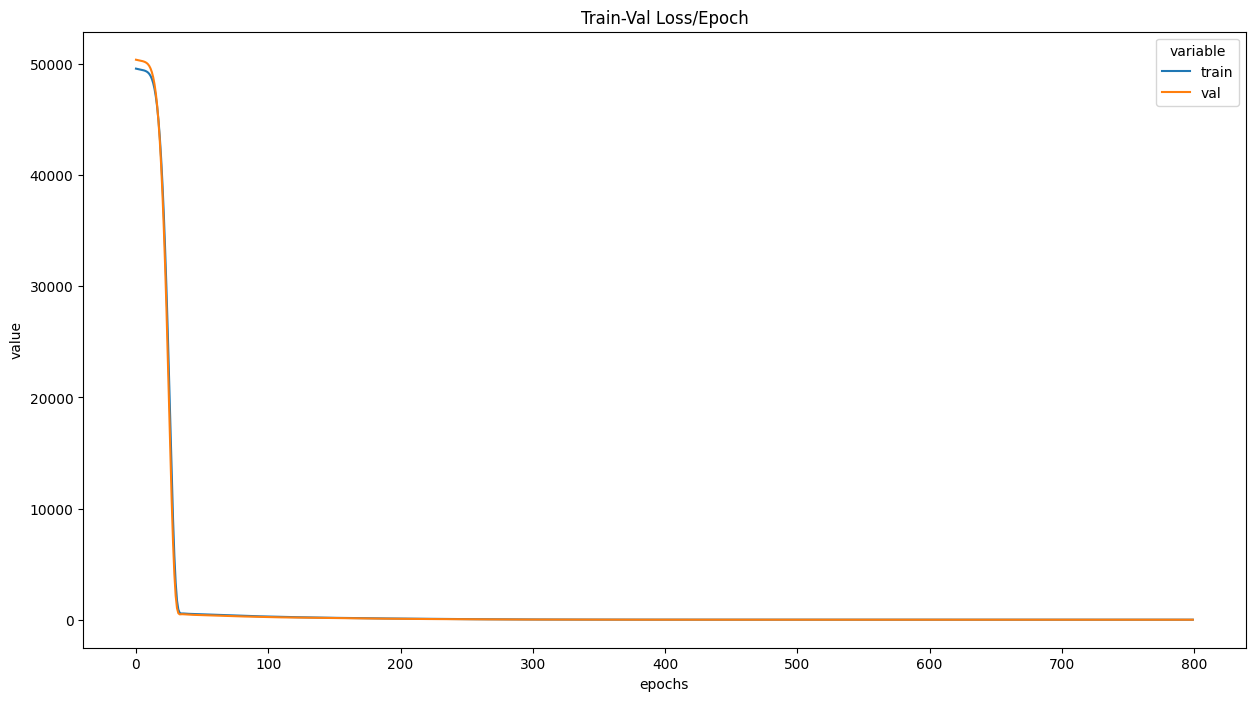

In [17]:
train_val_loss_df = (
    pd.DataFrame.from_dict(loss_stats)
    .reset_index()
    .melt(id_vars=["index"])
    .rename(columns={"index": "epochs"})
)
plt.figure(figsize=(15, 8))
sns.lineplot(data=train_val_loss_df, x="epochs", y="value", hue="variable").set_title(
    "Train-Val Loss/Epoch"
)

100%|██████████| 3/3 [00:00<00:00, 16754.88it/s]

[336.96356, 336.64252, 340.71677, 342.29553, 343.45023, 337.23828, 337.759, 332.13885, 333.39062, 332.71912, 328.79727, 330.3875, 332.12558, 332.88165, 330.36353, 329.18488, 328.87125, 327.5279, 328.05685, 330.98444, 333.3972, 339.51443, 341.21396, 342.13647, 346.4463, 345.5431, 345.255, 346.66327, 350.92737, 352.785, 354.39066, 356.04767, 356.4689, 357.15765, 358.38342, 355.06006, 354.5857, 351.4393, 348.61462, 347.5456, 346.3832, 344.3294, 340.27536, 340.35983, 337.10123, 337.54166, 337.19406, 336.9173, 334.03442, 334.51962, 333.85257, 335.09705, 334.92093, 335.46326, 337.94366, 338.41345, 343.25546, 343.1444, 345.8022, 345.92847, 341.73788, 339.12305, 340.2078, 340.89465, 338.2087, 336.66315, 333.2328, 335.07404, 333.35992, 333.92316, 333.1819, 331.2515, 330.63684, 329.82727, 329.34833, 332.26575, 331.2972, 333.287, 333.55185, 333.5396, 334.41373, 330.1916, 331.0343, 331.22318, 332.1929, 332.86386, 333.5448, 336.0967, 339.2719, 337.9793, 341.0852, 340.92273, 347.5775, 352.71912, 359

[Text(0.5, 1.0, 'Deviation of Error')]

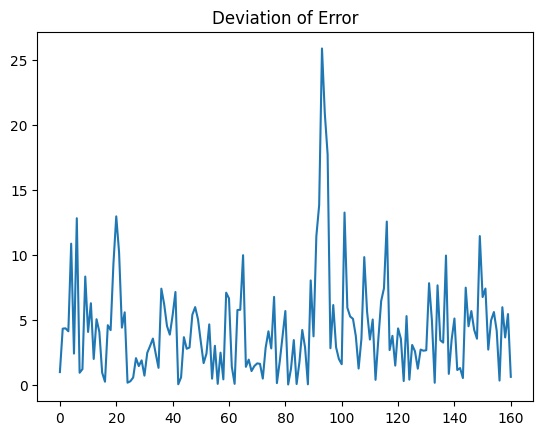

In [18]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
        y_pred_list = [a for a in y_pred_list]
        
y_pred = []
for i in tqdm(range(len(y_pred_list))):
    for j in range(len(y_pred_list[i])):
        for k in range(len(y_pred_list[i][j])):
            y_pred.append(y_pred_list[i][j][k])

print(y_pred)  
print(y_test.tolist())
y_pred_np = np.array(y_pred)
difference = np.subtract(y_pred_np, y_test)
difference = abs(difference)
mean_difference = np.mean(difference)
print(f"The average deviation in error is: {mean_difference}")
sns.lineplot(difference).set(title="Deviation of Error")

In [19]:
mse = mean_squared_error(y_test, y_pred)
r_square = r2_score(y_test, y_pred)
mean_abs_err = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Squared Error :",mse)
print("R^2 :",r_square)
print(f"Accuracy (using MSE): {(100 - mse)}%")
print(f"Mean absolute percentage error: {100 - mean_abs_err}%")

Mean Squared Error : 33.50143745412175
R^2 : 0.9616992762291434
Accuracy (using MSE): 66.49856254587826%
Mean absolute percentage error: 99.98824277468262%


#### Visualising the data

In [20]:
import plotly as py
import plotly.io as pio    
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [21]:
test_vals = temp.index[x_len:]
fig = make_subplots(rows=4, cols=1)
fig.add_trace(go.Scatter(x=temp.index, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)


fig.add_trace(go.Scatter(x=test_vals,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)


fig.add_trace(go.Scatter(x=test_vals,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple'), row=2, col=1)


fig.add_trace(go.Scatter(x=test_vals,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=3, col=1)

# )


fig.show()

In [22]:
temp = temp[int(0.8 * len(temp)) + 6:].copy()
close = temp.Close.to_list()
weekly_change = []
for i in range(len(close)-7):
    weekly_change.append(close[i] - close[i+7])
for i in range(len(close) -7,len(close)):
    weekly_change.append(weekly_change[i-7])

weekly_trend = []
for i in weekly_change:
    if i > 0:
        weekly_trend.append("Up")
    elif i < 0:
        weekly_trend.append("Down")
    else:
        weekly_trend.append("Flat")
temp['Weekly Trend'] = weekly_trend

monthly_change = []
for i in range(len(close)-30):
    monthly_change.append(close[i] - close[i+30])
for i in range(len(close) -30,len(close)):
    monthly_change.append(weekly_change[i-30])

monthly_trend = []
for i in monthly_change:
    if i > 0:
        monthly_trend.append("Up")
    elif i < 0:
        monthly_trend.append("Down")
    else:
        monthly_trend.append("Flat")
temp['Monthly Trend'] = monthly_trend


In [33]:
temp

,Date,Open,High,Low,Close,Adj Close,Volume,Weekly Trend,Monthly Trend,Weekly Predictions Trend,Monthly Preds Trend
674,2022-09-20,338.750000,339.600006,335.000000,336.000000,330.783295,9526068,Up,Down,Up,Down
675,2022-09-21,336.000000,345.200012,335.500000,340.950012,335.656433,20992080,Up,Down,Up,Down
676,2022-09-22,341.000000,348.750000,340.899994,345.049988,339.692749,24179987,Up,Down,Up,Down
677,2022-09-23,347.500000,349.549988,343.299988,346.399994,341.021820,22838807,Up,Down,Up,Down
678,2022-09-26,344.850006,345.950012,331.750000,332.600006,327.436066,16205789,Down,Down,Up,Down
...,...,...,...,...,...,...,...,...,...,...,...
830,2023-05-10,423.950012,426.350006,422.200012,425.350006,425.350006,9754485,Up,Down,Down,Down
831,2023-05-11,427.250000,427.399994,418.899994,420.399994,420.399994,15982423,Up,Down,Down,Down
832,2023-05-12,420.399994,422.700012,416.049988,420.450012,420.450012,11135894,Up,Down,Down,Down
833,2023-05-15,420.000000,428.700012,419.049988,427.799988,427.799988,9151102,Down,Down,Down,Down


In [24]:
preds = y_pred
weekly_preds_change = []
for i in range(len(preds)-7):
    weekly_preds_change.append(preds[i] - preds[i+7])
for i in range(len(preds) -7,len(preds)):
    weekly_preds_change.append(weekly_preds_change[i-7])

weekly_preds_trend = []
for i in weekly_preds_change:
    if i > 0:
        weekly_preds_trend.append("Up")
    elif i < 0:
        weekly_preds_trend.append("Down")
    else:
        weekly_preds_trend.append("Flat")
temp['Weekly Predictions Trend'] = weekly_preds_trend

monthly_preds_change = []
for i in range(len(preds)-30):
    monthly_preds_change.append(preds[i] - preds[i+30])
for i in range(len(preds) -30,len(preds)):
    monthly_preds_change.append(monthly_preds_change[i-30])

monthly_preds_trend = []
for i in monthly_preds_change:
    if i > 0:
        monthly_preds_trend.append("Up")
    elif i < 0:
        monthly_preds_trend.append("Down")
    else:
        monthly_preds_trend.append("Flat")
temp['Monthly Preds Trend'] = monthly_preds_trend

161


In [29]:
weekly_accuracy = 0
weekly = temp['Weekly Trend'].to_list()
weekly_preds = temp['Weekly Predictions Trend'].to_list()
for i in range(len(weekly)):
    if weekly[i] == weekly_preds[i]:
        weekly_accuracy += 1/len(weekly)
print(weekly_accuracy)

0.7329192546583861


In [34]:
monthly_accuracy = 0
monthly = temp['Monthly Trend'].to_list()
monthly_preds = temp['Monthly Preds Trend'].to_list()
for i in range(len(monthly)):
    if monthly[i] == monthly_preds[i]:
        monthly_accuracy += 1/len(weekly)
print(monthly_accuracy)

0.863354037267082


In [37]:
temp['Weekly Accuracy'] = weekly_accuracy
temp['Monthly Accuracy'] = monthly_accuracy

In [38]:
temp

,Date,Open,High,Low,Close,Adj Close,Volume,Weekly Trend,Monthly Trend,Weekly Predictions Trend,Monthly Preds Trend,Weekly Accuracy,Monthly Accuracy
674,2022-09-20,338.750000,339.600006,335.000000,336.000000,330.783295,9526068,Up,Down,Up,Down,0.732919,0.863354
675,2022-09-21,336.000000,345.200012,335.500000,340.950012,335.656433,20992080,Up,Down,Up,Down,0.732919,0.863354
676,2022-09-22,341.000000,348.750000,340.899994,345.049988,339.692749,24179987,Up,Down,Up,Down,0.732919,0.863354
677,2022-09-23,347.500000,349.549988,343.299988,346.399994,341.021820,22838807,Up,Down,Up,Down,0.732919,0.863354
678,2022-09-26,344.850006,345.950012,331.750000,332.600006,327.436066,16205789,Down,Down,Up,Down,0.732919,0.863354
...,...,...,...,...,...,...,...,...,...,...,...,...,...
830,2023-05-10,423.950012,426.350006,422.200012,425.350006,425.350006,9754485,Up,Down,Down,Down,0.732919,0.863354
831,2023-05-11,427.250000,427.399994,418.899994,420.399994,420.399994,15982423,Up,Down,Down,Down,0.732919,0.863354
832,2023-05-12,420.399994,422.700012,416.049988,420.450012,420.450012,11135894,Up,Down,Down,Down,0.732919,0.863354
833,2023-05-15,420.000000,428.700012,419.049988,427.799988,427.799988,9151102,Down,Down,Down,Down,0.732919,0.863354
